In [1]:
!pip install sentencepiece

In [2]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

# torch version
print(torch.__version__)

2.8.0+cu126


In [3]:
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/kowiki.txt.zip

--2025-09-12 06:16:20--  https://d3s0tskafalll9.cloudfront.net/media/documents/kowiki.txt.zip
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 3.165.160.23, 3.165.160.93, 3.165.160.100, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|3.165.160.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243123354 (232M) [application/zip]
Saving to: ‘kowiki.txt.zip’

kowiki.txt.zip      100%[===================>] 231.86M   219MB/s    in 1.1s    

2025-09-12 06:16:21 (219 MB/s) - ‘kowiki.txt.zip’ saved [243123354/243123354]



In [4]:
!unzip '/content/kowiki.txt.zip'

Archive:  /content/kowiki.txt.zip
  inflating: kowiki.txt              


In [5]:
import sentencepiece as spm
vocab=so=spm.SentencePieceProcessor()
vocab.load('/content/ko_8000.model')
print('vocab size: ', len(vocab))

vocab size:  8005


In [6]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

config = Config({
    'n_seq': 128,
    'd_model': 64,
    'n_head': 4,
    'd_ff': 256,
    'n_vocab': len(vocab),
    'i_pad': 0,
    'dropout': 0.1,
    'n_layers': 4,
})

print(config.n_seq, config.n_vocab)


128 8005


In [7]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """

    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)
    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [8]:
def trim_tokens(tokens_a, tokens_b, max_seq):
  while True:
    total_length=len(tokens_a)+len(tokens_b)
    if total_length<=max_seq:
        break
    if len(tokens_a)>len(tokens_b):
      del tokens_a[0]
    else:
      tokens_b.pop()


In [9]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):

        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [10]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for inst in instances:
            out_f.write(json.dumps(inst, ensure_ascii=False) + "\n")

    vocab_list = [vocab.id_to_piece(i) for i in range(5, len(vocab)) if not vocab.is_unknown(i)]

    line_cnt = sum(1 for _ in open(in_file, "r", encoding="utf-8"))

    with open(in_file, "r", encoding="utf-8") as in_f, open(out_file, "w", encoding="utf-8") as out_f:
        doc = []
        from tqdm import tqdm
        for line in tqdm(in_f, total=line_cnt):
            line = line.strip()
            if line == "":
                if doc:
                    save_pretrain_instances(out_f, doc)
                    doc = []
            else:
                pieces = vocab.encode_as_pieces(line)
                if pieces:
                    doc.append(pieces)
        if doc:
            save_pretrain_instances(out_f, doc)

corpus_file = '/content/kowiki.txt'
pretrain_json_path = '/content/bert_pretrain_ko.jsonl'
make_pretrain_data(vocab, corpus_file, pretrain_json_path, n_seq=config.n_seq, mask_prob=0.15)


100%|██████████| 3957761/3957761 [05:15<00:00, 12538.29it/s]


In [11]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    total = 0
    with open(filename, "r", encoding="utf-8") as f:
        for _ in f:
            total += 1
            if count is not None and total >= count: break

    enc_tokens = np.memmap('enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments   = np.memmap('segments.memmap',   mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap('labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap('labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r", encoding="utf-8") as f:
        from tqdm import tqdm
        for i, line in enumerate(tqdm(f, total=total)):
            if i >= total: break
            data = json.loads(line)
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            seg = data["segment"]; seg += [0] * (n_seq - len(seg))
            label_nsp = data["is_next"]
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.zeros(n_seq, dtype=np.int32)
            label_mlm[mask_idx] = mask_label

            enc_tokens[i] = np.array(enc_token, dtype=np.int32)
            segments[i]   = np.array(seg, dtype=np.int32)
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

(inputs_enc, inputs_seg), (labels_nsp, labels_mlm) = load_pre_train_data(vocab, pretrain_json_path, config.n_seq, count=None)


100%|██████████| 918173/918173 [02:08<00:00, 7125.93it/s]


In [12]:
from torch.utils.data import Dataset, DataLoader
class MemmapBertDataset(Dataset):
    def __init__(self, enc_tokens, segments, labels_nsp, labels_mlm):
        self.enc_tokens = enc_tokens
        self.segments = segments
        self.labels_nsp = labels_nsp
        self.labels_mlm = labels_mlm
        self.n = enc_tokens.shape[0]

    def __len__(self): return self.n

    def __getitem__(self, idx):
        x_tok = torch.from_numpy(self.enc_tokens[idx].copy()).long()
        x_seg = torch.from_numpy(self.segments[idx].copy()).long()
        y_nsp = torch.tensor(self.labels_nsp[idx]).long()
        y_mlm = torch.from_numpy(self.labels_mlm[idx].copy()).long()
        return x_tok, x_seg, y_nsp, y_mlm

dataset = MemmapBertDataset(inputs_enc, inputs_seg, labels_nsp, labels_mlm)
loader  = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)


In [13]:
def get_pad_mask(tokens: torch.Tensor, i_pad: int = 0):
    return (tokens == i_pad).unsqueeze(1).unsqueeze(2).float()

def gelu(x: torch.Tensor):
    return F.gelu(x)


def kernel_initializer_(tensor: torch.Tensor, stddev: float = 0.02):
    """Usual BERT init: truncated normal ~ N(0, std^2)."""
    return nn.init.trunc_normal_(tensor, std=stddev)


def bias_initializer_(tensor: torch.Tensor):
    return nn.init.zeros_(tensor)


class SharedEmbedding(nn.Module):
    def __init__(self, config: Config, name: str = "weight_shared_embedding"):
        super().__init__()
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        self.shared_weights = nn.Parameter(torch.empty(self.n_vocab, self.d_model))
        kernel_initializer_(self.shared_weights)

    def forward(self, inputs, mode: str = "embedding"):
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid")

    def _embedding(self, inputs):
        inputs = torch.clamp(inputs, max=self.shared_weights.size(0) - 1).long()
        return self.shared_weights[inputs]  # (bs, n_seq, d_model)

    def _linear(self, inputs):
        # inputs: (bs, n_seq, d_model) -> logits: (bs, n_seq, n_vocab)
        n_batch, n_seq, _ = inputs.shape
        flat = inputs.view(-1, self.d_model)  # (bs*n_seq, d_model)
        logits = torch.matmul(flat, self.shared_weights.t())  # (bs*n_seq, n_vocab)
        return logits.view(n_batch, n_seq, self.n_vocab)


class PositionalEmbedding(nn.Module):
    def __init__(self, config: Config, name='position_embedding'):
        super().__init__()
        self.n_seq = config.n_seq
        self.d_model = config.d_model
        self.embedding = nn.Embedding(self.n_seq, self.d_model)
        kernel_initializer_(self.embedding.weight)

    def forward(self, inputs):
        pos = torch.cumsum(torch.ones_like(inputs), dim=1) - 1
        pos = pos.long()
        return self.embedding(pos)

class SegmentEmbedding(nn.Module):
    def __init__(self, config: Config, name='segment_embedding'):
        super().__init__()
        self.embedding = nn.Embedding(2, config.d_model)
        kernel_initializer_(self.embedding.weight)

    def forward(self, segments):
        return self.embedding(segments.long())  # (bs, n_seq, d_model)


class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K, V, attn_mask):
        # Q,K,V: (bs, n_head, n_seq, d_head)
        attn_score = torch.matmul(Q, K.transpose(-2, -1))  # (bs, n_head, n_seq, n_seq)
        attn_scale = attn_score / math.sqrt(K.size(-1))

        attn_mask = attn_mask.to(dtype=attn_scale.dtype, device=attn_scale.device)
        big_neg = torch.tensor(1e9, dtype=attn_scale.dtype, device=attn_scale.device)
        attn_scale = attn_scale - attn_mask * big_neg

        attn_prob = F.softmax(attn_scale, dim=-1)
        out = torch.matmul(attn_prob, V)               # (bs, n_head, n_seq, d_head)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        assert config.d_model % config.n_head == 0
        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_model // config.n_head
        self.dropout = nn.Dropout(config.dropout)

        self.W_Q = nn.Linear(self.d_model, self.n_head * self.d_head)
        self.W_K = nn.Linear(self.d_model, self.n_head * self.d_head)
        self.W_V = nn.Linear(self.d_model, self.n_head * self.d_head)
        self.out  = nn.Linear(self.n_head * self.d_head, self.d_model)

        for m in [self.W_Q, self.W_K, self.W_V, self.out]:
            kernel_initializer_(m.weight)
            if m.bias is not None:
                bias_initializer_(m.bias)

        self.attn = ScaleDotProductAttention()
        self.norm = nn.LayerNorm(self.d_model)

    def forward(self, x, attn_mask):
        bs, n_seq, _ = x.shape

        Q = self.W_Q(x).view(bs, n_seq, self.n_head, self.d_head).transpose(1, 2)  # (bs, h, seq, d_h)
        K = self.W_K(x).view(bs, n_seq, self.n_head, self.d_head).transpose(1, 2)
        V = self.W_V(x).view(bs, n_seq, self.n_head, self.d_head).transpose(1, 2)

        attn_mask_full = attn_mask.expand(bs, self.n_head, n_seq, n_seq)

        attn_out = self.attn(Q, K, V, attn_mask_full)  # (bs, h, seq, d_h)
        attn_out = attn_out.transpose(1, 2).contiguous().view(bs, n_seq, self.n_head * self.d_head)
        attn_out = self.out(attn_out)
        attn_out = self.dropout(attn_out)

        # Residual + LayerNorm
        return self.norm(x + attn_out)

class PositionwiseFFN(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.fc1 = nn.Linear(config.d_model, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, config.d_model)
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_model)

        for m in [self.fc1, self.fc2]:
            kernel_initializer_(m.weight)
            if m.bias is not None: bias_initializer_(m.bias)

    def forward(self, x):
        y = self.fc2(self.dropout(gelu(self.fc1(x))))
        y = self.dropout(y)
        return self.norm(x + y)  # residual


class EncoderLayer(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.mha = MultiHeadAttention(config)
        self.ffn = PositionwiseFFN(config)

    def forward(self, x, attn_mask):
        x = self.mha(x, attn_mask)
        x = self.ffn(x)
        return x


class BERT(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        self.embedding = SharedEmbedding(config)       # token emb + tied output weights
        self.position  = PositionalEmbedding(config)
        self.segment   = SegmentEmbedding(config)
        self.norm      = nn.LayerNorm(config.d_model)
        self.dropout   = nn.Dropout(config.dropout)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(config) for _ in range(config.n_layers)]
        )

    def get_embedding(self, tokens, segments):
        x = self.embedding(tokens, mode="embedding") \
            + self.position(tokens) \
            + self.segment(segments)
        x = self.norm(x)
        x = self.dropout(x)
        return x

    def forward(self, enc_tokens, segments):

        x = self.get_embedding(enc_tokens, segments)
        enc_self_mask = get_pad_mask(enc_tokens, i_pad=self.config.i_pad)  # (bs,1,1,n_seq)

        for layer in self.encoder_layers:
            x = layer(x, enc_self_mask)
        cls_repr = x[:, 0]  # (bs, d_model)

        logits_lm = self.embedding(x, mode="linear")  # (bs, n_seq, n_vocab)
        return cls_repr, logits_lm


class PooledOutput(nn.Module):
    def __init__(self, config: Config, n_output: int, name="pooled_output"):
        super().__init__()
        self.dense1 = nn.Linear(config.d_model, config.d_model)
        self.dense2 = nn.Linear(config.d_model, n_output, bias=False)
        kernel_initializer_(self.dense1.weight); bias_initializer_(self.dense1.bias)
        kernel_initializer_(self.dense2.weight)

    def forward(self, inputs):
        x = torch.tanh(self.dense1(inputs))
        x = self.dense2(x)  # (bs, n_output), сырые логиты
        return x


class PreTrainModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.bert = BERT(config)
        self.pooled_output = PooledOutput(config, n_output=2)

    def forward(self, enc_tokens, segments):
        enc_tokens = enc_tokens.long()
        segments   = segments.long()
        cls_repr, logits_lm = self.bert(enc_tokens, segments)  # (bs,d_model), (bs,seq,vocab)
        logits_cls = self.pooled_output(cls_repr)               # (bs,2)
        return logits_cls, logits_lm


def build_model_pre_train(config: Config):
    return PreTrainModel(config)


In [14]:
CE_nsp = nn.CrossEntropyLoss()
CE_mlm = nn.CrossEntropyLoss(ignore_index=0)

In [15]:
def nsp_acc_fn(logits, y):
    pred = logits.argmax(-1)
    return (pred == y).float().mean().item()

def mlm_acc_fn(logits_lm, y_true):
    mask = (y_true > 0)
    if mask.sum() == 0: return 0.0
    pred = logits_lm.argmax(-1)
    correct = (pred[mask] == y_true[mask]).float().mean().item()
    return correct


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cuda')

In [18]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
model = PreTrainModel(config).to(device)
epochs = 10
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

total_steps = len(loader) * epochs
warmup_steps = int(0.1 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return max(0.0, float(total_steps - step) / float(max(1, total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda)


In [19]:
!pip install torchinfo

In [20]:
from torchinfo import summary


In [21]:
summary(model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 64]                  --
│    └─SharedEmbedding: 2-1                                  [10, 128, 64]             512,320
│    └─PositionalEmbedding: 2-2                              [10, 128, 64]             --
│    │    └─Embedding: 3-1                                   [10, 128, 64]             8,192
│    └─SegmentEmbedding: 2-3                                 [10, 128, 64]             --
│    │    └─Embedding: 3-2                                   [10, 128, 64]             128
│    └─LayerNorm: 2-4                                        [10, 128, 64]             128
│    └─Dropout: 2-5                                          [10, 128, 64]             --
│    └─ModuleList: 2-6                                       --                      

In [22]:
from tqdm.notebook import tqdm

history = {
    'step': [], 'epoch': [],
    'loss': [], 'loss_mlm': [], 'loss_nsp': [],
    'mlm_acc': [], 'nsp_acc': [],
}
history_epoch = {
    'epoch': [],
    'loss': [], 'loss_mlm': [], 'loss_nsp': [],
    'mlm_acc': [], 'nsp_acc': [],
}

global_step = 0
for epoch in range(1, epochs + 1):
    model.train()
    sum_loss = 0.0
    sum_loss_mlm = 0.0
    sum_loss_nsp = 0.0
    sum_mlm_acc = 0.0
    sum_nsp_acc = 0.0
    n_batches = 0

    pbar = tqdm(enumerate(loader, 1),
                total=len(loader),
                desc=f"Epoch {epoch}/{epochs}",
                leave=True)

    for batch_idx, (enc_tok, seg, y_nsp, y_mlm) in pbar:
        enc_tok, seg = enc_tok.to(device), seg.to(device)
        y_nsp, y_mlm = y_nsp.to(device), y_mlm.to(device)

        logits_cls, logits_lm = model(enc_tok, seg)

        loss_nsp = CE_nsp(logits_cls, y_nsp)
        # shape: logits_lm [B, T, V] -> [B*T, V]; y_mlm [B, T] -> [B*T]
        loss_mlm = CE_mlm(logits_lm.view(-1, config.n_vocab), y_mlm.view(-1))
        loss = loss_nsp + loss_mlm

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        global_step += 1

        with torch.no_grad():
            nsp_acc = (logits_cls.argmax(-1) == y_nsp).float().mean().item()
            mask = (y_mlm > 0)
            if mask.any():
                mlm_pred = logits_lm.argmax(-1)  # [B, T]
                mlm_acc = (mlm_pred[mask] == y_mlm[mask]).float().mean().item()
            else:
                mlm_acc = 0.0

        history['step'].append(global_step)
        history['epoch'].append(epoch)
        history['loss'].append(loss.item())
        history['loss_mlm'].append(loss_mlm.item())
        history['loss_nsp'].append(loss_nsp.item())
        history['mlm_acc'].append(mlm_acc)
        history['nsp_acc'].append(nsp_acc)


        sum_loss += loss.item()
        sum_loss_mlm += loss_mlm.item()
        sum_loss_nsp += loss_nsp.item()
        sum_mlm_acc += mlm_acc
        sum_nsp_acc += nsp_acc
        n_batches += 1

        avg_loss = sum_loss / n_batches
        avg_mlm = sum_loss_mlm / n_batches
        avg_nsp = sum_loss_nsp / n_batches
        avg_mlm_acc = sum_mlm_acc / n_batches
        avg_nsp_acc = sum_nsp_acc / n_batches

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "avg": f"{avg_loss:.4f}",
            "mlm": f"{avg_mlm:.4f}",
            "nsp": f"{avg_nsp:.4f}",
            "mlm_acc": f"{avg_mlm_acc:.3f}",
            "nsp_acc": f"{avg_nsp_acc:.3f}",
        })


    epoch_loss = sum_loss / n_batches
    epoch_loss_mlm = sum_loss_mlm / n_batches
    epoch_loss_nsp = sum_loss_nsp / n_batches
    epoch_mlm_acc = sum_mlm_acc / n_batches
    epoch_nsp_acc = sum_nsp_acc / n_batches

    print(f"[Epoch {epoch:02d}] "
          f"loss: {epoch_loss:.4f} | "
          f"mlm_loss: {epoch_loss_mlm:.4f} | nsp_loss: {epoch_loss_nsp:.4f} | "
          f"mlm_acc: {epoch_mlm_acc:.3f} | nsp_acc: {epoch_nsp_acc:.3f}")

    history_epoch['epoch'].append(epoch)
    history_epoch['loss'].append(epoch_loss)
    history_epoch['loss_mlm'].append(epoch_loss_mlm)
    history_epoch['loss_nsp'].append(epoch_loss_nsp)
    history_epoch['mlm_acc'].append(epoch_mlm_acc)
    history_epoch['nsp_acc'].append(epoch_nsp_acc)


Epoch 1/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 01] loss: 7.9507 | mlm_loss: 7.4855 | nsp_loss: 0.4652 | mlm_acc: 0.050 | nsp_acc: 0.720


Epoch 2/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 02] loss: 6.9414 | mlm_loss: 6.5563 | nsp_loss: 0.3851 | mlm_acc: 0.120 | nsp_acc: 0.760


Epoch 3/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 03] loss: 6.6157 | mlm_loss: 6.2413 | nsp_loss: 0.3744 | mlm_acc: 0.136 | nsp_acc: 0.763


Epoch 4/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 04] loss: 6.3072 | mlm_loss: 5.9318 | nsp_loss: 0.3754 | mlm_acc: 0.151 | nsp_acc: 0.762


Epoch 5/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 05] loss: 5.8412 | mlm_loss: 5.4666 | nsp_loss: 0.3746 | mlm_acc: 0.176 | nsp_acc: 0.762


Epoch 6/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 06] loss: 5.6271 | mlm_loss: 5.2561 | nsp_loss: 0.3710 | mlm_acc: 0.191 | nsp_acc: 0.764


Epoch 7/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 07] loss: 5.5151 | mlm_loss: 5.1465 | nsp_loss: 0.3686 | mlm_acc: 0.200 | nsp_acc: 0.765


Epoch 8/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 08] loss: 5.4432 | mlm_loss: 5.0766 | nsp_loss: 0.3666 | mlm_acc: 0.206 | nsp_acc: 0.766


Epoch 9/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 09] loss: 5.4002 | mlm_loss: 5.0351 | nsp_loss: 0.3651 | mlm_acc: 0.209 | nsp_acc: 0.767


Epoch 10/10:   0%|          | 0/28693 [00:00<?, ?it/s]

[Epoch 10] loss: 5.3777 | mlm_loss: 5.0139 | nsp_loss: 0.3639 | mlm_acc: 0.211 | nsp_acc: 0.768


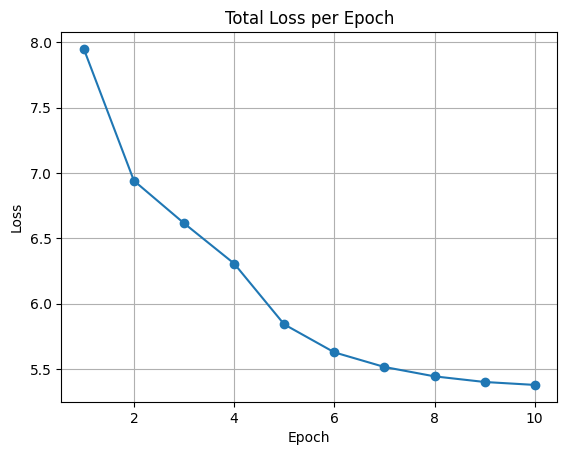

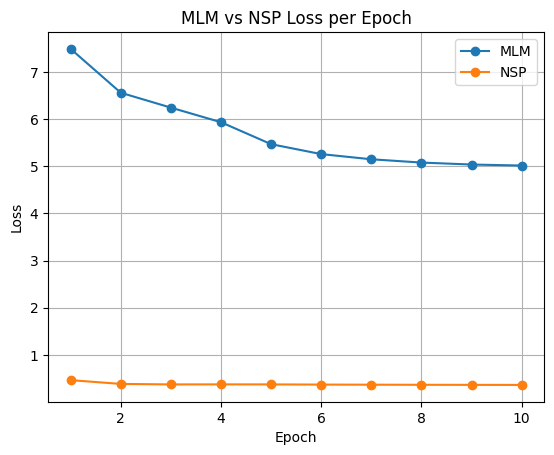

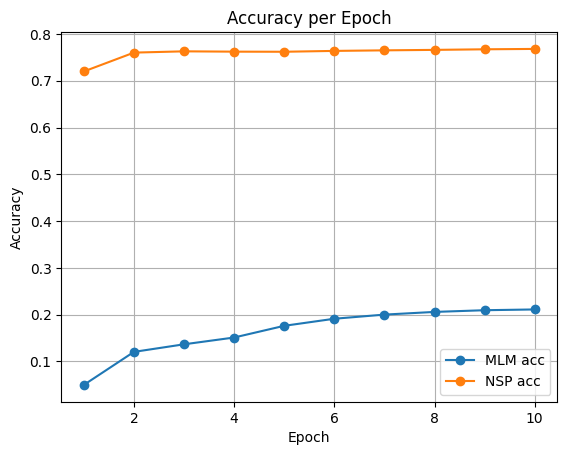

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_epoch['epoch'], history_epoch['loss'], marker='o')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Total Loss per Epoch'); plt.grid(True); plt.show()

plt.figure()
plt.plot(history_epoch['epoch'], history_epoch['loss_mlm'], marker='o', label='MLM')
plt.plot(history_epoch['epoch'], history_epoch['loss_nsp'], marker='o', label='NSP')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('MLM vs NSP Loss per Epoch'); plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(history_epoch['epoch'], history_epoch['mlm_acc'], marker='o', label='MLM acc')
plt.plot(history_epoch['epoch'], history_epoch['nsp_acc'], marker='o', label='NSP acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy per Epoch'); plt.legend(); plt.grid(True); plt.show()


# 회고:

그래프와 로그를 바탕으로 한 간단한 결론입니다.

# 수렴 확인:
Total loss가 약 7.95 → 5.38(≈–32%)로 감소. 1–4 epoch에서 급격히 내려가고, 8 epoch 이후는 완만한 plateau.

**MLM이 지배적:** mlm_loss 7.49 → 5.01(≈–33%), mlm_acc 0.05 → 0.21로 상승(약 4배). 총 loss의 대부분을 결정.

**NSP는 초반부터 높음:** nsp_acc 0.72 → ~0.77, nsp_loss 0.46 → 0.36(–22%). 태스크가 비교적 쉽거나 강한 신호가 존재.

**학습 안정적:** 급격한 스파이크/폭발 없음 → 옵티마이저·LR 스케줄 적절.



성능 향상은 거의 전부 MLM에서 발생, 8–10 epoch 구간은 체감 효익 감소.

NSP는 초반에 포화되어 총 loss에 미치는 추가 기여가 작음.

**다음 단계 제안**

조기 종료 고려: 8 epoch 전후에서 멈추면 효율적.

MLM 비중 강화:

loss 가중치 조정(예: loss = loss_mlm*1.0 + loss_nsp*0.25) 또는 NSP 제외 실험으로 비교.

MLM 라벨에 ignore_index=-100(마스크 외 위치) 사용 검토 → 정확도/손실 계산 일관성 향상.

검증 곡선 추가(val loss/acc)로 과적합 점검—현재는 train만 확인됨.